# makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xtest, Ytest = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (
    (5 / 3) / ((n_embd * block_size) ** 0.5)
)  # 0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * (
    1 / ((n_hidden) ** 0.5)
)  # 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros(n_hidden)
bnstd_running = torch.ones(n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [8]:
1 / ((n_hidden) ** 0.5)

0.07071067811865475

In [9]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [10]:
lri = []
lossi = []
stepi = []

In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps)):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # (32, 3, 2)
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1  # + b1  # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

    h = torch.tanh(hpreact)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.4f}")
    lossi.append(loss.log10().item())
print(loss.item())

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000 loss: 3.6702
  10000/ 200000 loss: 2.0310
  20000/ 200000 loss: 2.5991
  30000/ 200000 loss: 2.0311
  40000/ 200000 loss: 2.2747
  50000/ 200000 loss: 1.8810
  60000/ 200000 loss: 2.1123
  70000/ 200000 loss: 2.3104
  80000/ 200000 loss: 2.3838
  90000/ 200000 loss: 2.0555
 100000/ 200000 loss: 2.3456
 110000/ 200000 loss: 2.2557
 120000/ 200000 loss: 1.6611
 130000/ 200000 loss: 1.8733
 140000/ 200000 loss: 2.3256
 150000/ 200000 loss: 1.9549
 160000/ 200000 loss: 2.0183
 170000/ 200000 loss: 2.3910
 180000/ 200000 loss: 2.1503
 190000/ 200000 loss: 2.0741
2.0221877098083496


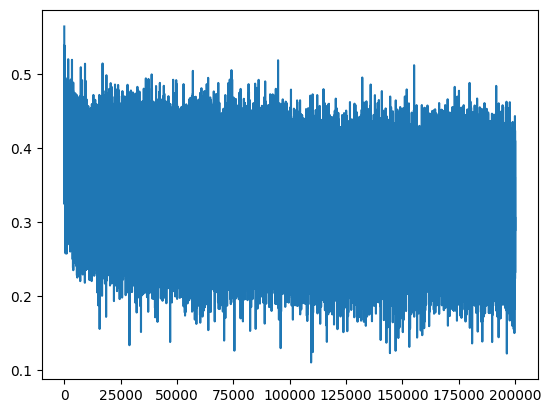

In [12]:
plt.plot(lossi)

In [13]:
# # calibrate the batch norm statistics
# with torch.no_grad():
#     emb = C[Xtr]  # (32, 3, 2)
#     embcat = emb.view((emb.shape[0], -1))
#     hpreact = embcat @ W1 + b1  # hidden layer pre-activation
#     # measure the mean and std over the entire dataset
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [17]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xtest, Ytest)}[split]
    emb = C[x]  # (32, 3, 2)
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1  # + b1  # hidden layer pre-activation
    # hpreact = (
    #     bngain
    #     * (hpreact - hpreact.mean(0, keepdim=True))
    #     / hpreact.std(0, keepdim=True)
    #     + bnbias
    # )
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (32, 100)    logits = h @ W2 + b2  # (32, 27)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item():.4f}")


split_loss("train")
split_loss("val")

train: 2.0687
val: 2.1081


In [19]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        embcat = emb.view((1, -1))
        hpreact = embcat @ W1  # + b1  # hidden layer pre-activation
        # hpreact = (
        #     bngain
        #     * (hpreact - hpreact.mean(0, keepdim=True))
        #     / hpreact.std(0, keepdim=True)
        #     + bnbias
        # )
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)  # (32, 100)    logits = h @ W2 + b2  # (32, 27)
        logits = h @ W2 + b2  # (32, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

mona.
mayah.
see.
mad.
ryla.
reisha.
ejdrie.
caileed.
elin.
shy.
jen.
eden.
sana.
arleigh.
malaia.
nosadbergihira.
sten.
joselynn.
novana.
ubrence.
ryyah.
fael.
yuma.
myston.
mahil.
salynn.
julian.
lee.
ren.
cre.
